<a href="https://www.cognitiveclass.ai"><img src = "https://cognitiveclass.ai/wp-content/themes/bdu3.0/static/images/cc-logo.png" align = left></a>

<br>
<br>

--------------------
# Search for Extra Terrestrial Intelligence (SETI)
###  SETI Signal Classification on PowerAI with Single GPU
<hr>
<br>

### Introduction
In this Notebook, we will use the famous [SETI Dataset](https://github.com/setiQuest/ML4SETI/) to build a Convolutional Neural Networks capable to perform signals classification. CNN will say, with some associated error, what type of signal is the presented input.

### Project overview:
Each night, using the Allen Telescope Array (ATA) in northern California, the SETI Institute scans the sky at various radio frequencies, observing star systems with known exoplanets, searching for faint but persistent signals. The current signal detection system is programmed to search only for particular kinds of signals: narrow-band carrier waves. However, the detection system sometimes triggers on signals that are not narrow-band signals  (with unknown efficiency) and are also not explicitly-known radio frequency interference (RFI). There seems to be various categories of these kinds of events that have been observed in the past.

Our goal is to classify these accurately in real-time. This may allow the signal detection system to make better observational decisions, increase the efficiency of the nightly scans, and allow for explicit detection of these other signal types.

For more information refer to [SETI hackathon page](https://github.com/setiQuest/ML4SETI/).


### Performance
Convelutional Neural Network involves a lot of matrix and vector multiplications that can parallelized, so GPUs can overperform, because GPUs were designed to handle these kind of matrix operations in parallel!

### Why GPU overperforms?
A single core CPU takes a matrix operation in serial, one element at a time. But, a single GPU could have hundreds or thousands of cores, while a CPU typically has no more than a few cores.


### How to use GPU with TensorFlow?
It is important to notice that if both CPU and GPU are available on the machine that you are running the noebook, and if a TensorFlow operation has both CPU and GPU implementations, the GPU devices will be given priority when the operation is assigned to a device. 

In our case, as we are running this notebook on [IBM PowerAI](http://cocl.us/SETI-NIMBIX-PowerAI), you hvae access to multi GPU, but lets use one of the GPUs in this notebook, for the sake of simplicity.

__Notice__: if sklearn library is not installed, you should uncomment and install it.

In [1]:
import requests
import json
#import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
import time
#!sudo pip install sklearn
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from six.moves import urllib
import sys
import tarfile
import numpy as np
#from utils import tile_raster_images
from PIL import Image


### Set the destination folder

In [2]:
### SET YOUR WORKING SPACE HERE! Use this folder to save intermediate results.
dataset_name = 'SETI_ds_64x128'
mydatafolder = "/tmp/SETI1_data/"
if os.path.exists(mydatafolder) is False:
    os.makedirs(mydatafolder)
print mydatafolder
print os.popen("ls -lrt "+ mydatafolder).read()
train_dir = '/tmp/SETI1_train/'
if os.path.exists(train_dir) is False:
    os.makedirs(train_dir)
print train_dir

/tmp/SETI1_data/
total 2384
-rw-r--r-- 1 nimbix nimbix 2432541 Oct 21 03:44 qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz
drwxr-xr-x 2 nimbix nimbix    4096 Oct 21 23:03 save
drwxr-xr-x 2 nimbix nimbix    4096 Oct 22 02:06 SETI_ds_64x128

/tmp/SETI1_train/


### Import dataset reader
The signals for this notebook, have been converted to spectogram images, and stored as 4 files.
The following cell will load a python code that help us to decode the binary file, and read the SETI dataset.

In [3]:
!wget -q --output-document  SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

Archive:  SETI.zip
  inflating: SETI.py                 
  inflating: __MACOSX/._SETI.py      


### Download data
Uncomment and run the next cell if you have not run the previouse notebook.  
The dataset exist and shared on IBM box. Running the following cell, you can download the dataset and extract it.

In [4]:
def maybe_download_and_extract():
    data_dir = "/tmp/SETI1_data/"
    DATA_URL =  'https://ibm.box.com/shared/static/qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz'
    dataset_name = 'SETI_ds_64x128'
    dest_directory = data_dir
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    extracted_dir_path = os.path.join(dest_directory, dataset_name)
    if not os.path.exists(extracted_dir_path):
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)
maybe_download_and_extract()

()
('Successfully downloaded', 'qz33lcio9ip2j8qi2atxqs62gn3bnu2s.gz', 2432541, 'bytes.')


### Load data SETI

In [5]:
ds_directory = mydatafolder + dataset_name
dataset = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
dataset.train.images.shape

Extracting /tmp/SETI1_data/SETI_ds_64x128/train-images-idx3-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/train-labels-idx1-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/test-images-idx3-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/test-labels-idx1-ubyte.gz


(2000, 8192)

### Understanding the imported data

The imported data can be divided as follow:

- Training (dataset.train) >>  Use the given dataset with inputs and related outputs for training of NN. In our case, if you give an image that you know that represents a "class1", this set will tell the neural network that we expect a "class1" as the output.  
        - 694 signals (images)
        - dataset.train.images for inputs
        - dataset.train.labels for outputs
  
  
- Test (mnist.test) >> the model does not have access to this informations prior to the test phase. It is used to evaluate the performance and accuracy of the model against "real life situations". No further optimization beyond this point.  
        - 10,000 data points
        - dataset.test.images for inputs
        - dataset.test.labels for outputs
        
        
#### Labels
- Each image (spectrum of signal) in the dataset has been labeled from 1 to 4, representing:
    - squiggle
    - narrowband
    - noise
    - narrowbanddrd

## Network Parameters

In [6]:
# Parameters
decay_rate=0.96
decay_steps=1000
learning_rate = 0.005
training_epochs = 10000
batch_size = 128
display_step = 100

#check point directory
chk_directory = mydatafolder + '/save/'
checkpoint_path = chk_directory + 'model.ckpt'


n_classes = 4 # number of possible classifications for the problem
dropout = 0.50 # Dropout, probability to keep units

height = 64 # height of the image in pixels 
width = 128 # width of the image in pixels 
n_input = width * height # number of pixels in one image 


### Inputs

It's a best practice to create placeholders before variable assignments when using TensorFlow. Here we'll create placeholders for inputs ("X") and outputs ("Y_").   

__Placeholder 'X':__ represents the "space" allocated input or the images. 
       * Each input has 8192 pixels distributed by a 64 width x 128 height matrix   
       * The 'shape' argument defines the tensor size by its dimensions.  
       * 1st dimension = None. Indicates that the batch size, can be of any size.  
       * 2nd dimension = 8192. Indicates the number of pixels on a single flattened spectogram image.  
      
__Placeholder 'Y':___ represents the final output or the labels.  
       * 4 possible classes (0,1,2,3)  
       * The 'shape' argument defines the tensor size by its dimensions.  
       * 1st dimension = None. Indicates that the batch size, can be of any size.   
       * 2nd dimension = 4. Indicates the number of targets/outcomes 

__dtype for both placeholders:__ if you not sure, use tf.float32. The limitation here is that the later presented softmax function only accepts float32 or float64 dtypes. For more dtypes, check TensorFlow's documentation <a href="https://www.tensorflow.org/versions/r0.9/api_docs/python/framework.html#tensor-types">here</a>

In [7]:
x  = tf.placeholder(tf.float32, shape=[None, n_input])
y_ = tf.placeholder(tf.float32, shape=[None, n_classes])

The input image is a 64 pixels by 128 pixels, 1 channel (grayscale). In this case, the first dimension is the __batch number__ of the image, and can be of any size (so we set it to -1). The second and third dimensions are width and hight, and the last one is the image channels.

In [8]:
x_image = tf.reshape(x, [-1,height,width,1]) 
x_image

<tf.Tensor 'Reshape:0' shape=(?, 64, 128, 1) dtype=float32>

### Convolutional neural networks (CNNs)

Convolutional neural networks (CNNs) is a type of feed-forward neural network, consist of multiple layers of  neurons that have learnable weights and biases. Each neuron in a layer that receives some input, process it, and optionally follows it with a non-linearity. The network has multiple layers such as convolution, max pool, drop out and fully connected layers. In each layer, small neurons process portions of the input image. The outputs of these collections are then tiled so that their input regions overlap, to obtain a higher-resolution representation of the original image; and it is repeated for every such layer. The important point here is: CNNs are able to break the complex patterns down into a series of simpler patterns, through multiple layers.

### CNN architecture
Now we are going to use a Deep Neural Network. 


Architecture of our network is:
    
- [Input] >>>> (batch_size, 64, 128, 1)  
- Apply 32 filter of (5x5)
- [Convolutional layer 1]  >>>> (batch_size, 64, 128, 32)
- [ReLU 1]  >>>> (batch_size, 64, 128, 32)
- [Max pooling 1] >>>> (batch_size, 32, 64, 32)
- Apply 64 filter of (5x5x32)
- [Convolutional layer 2]  >>>> (batch_size, 32, 64, 64)
- [ReLU 2]  >>>> (batch_size, 32, 64, 64)
- [Max pooling 2]  >>>> (batch_size, 8, 16, 64) 
- [fully connected layer] >>>> (batch_size, 1024)
- [ReLU]  >>>> (batch_size, 1024)
- [Drop out]  >>>> (batch_size, 1024)
- [fully connected layer 4] >>>> (batch_size, 1024)


The next cells will explore this new architecture.

#### Convolutional Layer 1
We define a kernle here. The Size of the filter/kernel is 5x5;  Input channels is 1 (greyscale);  and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So, the output of convolution layer would be 64x128x32). In this step, we create a filter / kernel tensor of shape `[filter_height, filter_width, in_channels, out_channels]`

- To creat convolutional layer, we use __tf.nn.conv2d__. It computes a 2-D convolution given 4-D input and filter tensors.
- The convolutional layer, slides the "kernel window" across the input tensor. As the input tensor has 4 dimensions:  [batch, height, width, channels], then the convolution operates on a 2D window on the height and width dimensions. __strides__ determines how much the window shifts by in each of the dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we coould set other values, e.g. [1, 2, 2, 1]
- __max pooling__ is a form of non-linear down-sampling. It partitions the input image into a set of rectangles and, and then find the maximum value for that region. Lets use __tf.nn.max_pool__ function to perform max pooling. 

In [9]:
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs
convolve1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
h_conv1 = tf.nn.relu(convolve1)
conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
conv1

<tf.Tensor 'MaxPool:0' shape=(?, 32, 64, 32) dtype=float32>

#### Convolutional Layer 2
We apply the convolution again in this layer. Lets look at the second layer kernel:  
- Filter/kernel: 5x5x32
- Input channels: 32 (from the 1st Conv layer, we had 32 feature maps) , so we use 64 output feature maps  

In [10]:
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs
convolve2= tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')+ b_conv2
h_conv2 = tf.nn.relu(convolve2)
conv2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 4, 4, 1], padding='SAME') #max_pool_2x2
conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 8, 16, 64) dtype=float32>

#### Fully Connected Layer

You need a fully connected layer to use the Softmax and create the probabilities in the end. Fully connected layers take the high-level filtered images from previous layer, that is all the 64 matrics, and convert them to a flat array.

So, the matrix (8x16)x64 will be converted to a matrix of size (1x102).

In [11]:
input_layer = conv2
dim = input_layer.get_shape().as_list()
dim

[None, 8, 16, 64]

In [12]:
dims= dim[1]*dim[2]*dim[3]
nodes1 = 1024
prv_layer_matrix = tf.reshape(input_layer, [-1, dims])
W_fc1 = tf.Variable(tf.truncated_normal([dims, nodes1], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[nodes1])) # need 1024 biases for 1024 outputs
h_fcl1  = tf.matmul(prv_layer_matrix, W_fc1) + b_fc1
fc_layer1 = tf.nn.relu(h_fcl1) # ???
fc_layer1


<tf.Tensor 'Relu_2:0' shape=(?, 1024) dtype=float32>

#### Droupout 1
It is a phase where the network "forget" some features. At each training step in a mini-batch, some units get switched off randomly so that it will not interact with the network. That is, it weights cannot be updated, nor affect the learning of the other network nodes.  This can be very useful for very large neural networks to prevent overfitting.

In [13]:
keep_prob = tf.placeholder(tf.float32)
layer_drop1 = tf.nn.dropout(fc_layer1, keep_prob)

#### Readout Layer
In last layer, CNN takes the high-level filtered images and translate them into votes using softmax. __softmax__ allows us to interpret the outputs of __fcl4__ as probabilities. So, __y_conv__ is a tensor of probablities.
Input channels os this layer is 1024 (neurons from the 3rd Layer) pixel, and output features are 4 classes. 

In [14]:
W_fc = tf.Variable(tf.truncated_normal([nodes1, n_classes], stddev=0.1)) #1024 neurons
b_fc = tf.Variable(tf.constant(0.1, shape=[n_classes])) # 10 possibilities for classes [0,1,2,3]
fc = tf.matmul(layer_drop1, W_fc) + b_fc
y_CNN= tf.nn.softmax(fc)

#### Loss function
We need to compare our output, layer4 tensor, with ground truth for all mini_batch. we can use __cross entropy__ to see how bad our CNN is working - to measure the error at a softmax layer. __softmax_cross_entropy_with_logits__ 
computes softmax cross entropy between logits and labels, and __reduce_mean__ computes the mean of all elements in the tensor.

In [15]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_CNN, labels=y_))

#### Training
It is obvious that we want minimize the error of our network which is calculated by cross_entropy metric. To solve the problem, we have to compute gradients for the loss (which is minimizing the cross-entropy) and apply gradients to variables. It will be done by an optimizer: GradientDescent. 

In [16]:
# Create a variable to track the global step.
global_step = tf.Variable(0, trainable=False)

# create learning_decay
lr = tf.train.exponential_decay( learning_rate,
                                 global_step,
                                 decay_steps,
                                 decay_rate, staircase=True )

In [17]:
# Use the optimizer to apply the gradients that minimize the loss
# (and also increment the global step counter) as a single training step.
optimizer = tf.train.GradientDescentOptimizer(lr)

train_op = optimizer.minimize(cross_entropy, global_step=global_step)
#train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

#### Evaluation
Do you want to know how many of the cases in a mini-batch has been classified correctly? lets count them.

In [18]:
correct_prediction = tf.equal(tf.argmax(y_CNN,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Create checkpoint directory

In [19]:
directory = os.path.dirname(chk_directory)
try:
    os.stat(directory)
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    print ckpt
except:
    os.mkdir(directory) 

model_checkpoint_path: "/tmp/SETI1_data//save/model.ckpt-140000"
all_model_checkpoint_paths: "/tmp/SETI1_data//save/model.ckpt-140000"



<div class="alert alert-success alertsuccess" style="margin-top: 20px">
<font size = 3><strong>*You can run this cell if you REALLY have time to wait, or you are running it using PowerAI </strong></font>


What is PowerAI?

Running deep learning programs usually needs a high performance platform. PowerAI speeds up deep learning and AI. Built on IBM's Power Systems, PowerAI is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The PowerAI platform supports popular machine learning libraries and dependencies including Tensorflow, Caffe, Torch, and Theano. You can download a [free version of PowerAI](https://cocl.us/DX0108EN-PowerAI).


__Notice:__ If you are running this notebook on PowerAI, it will automatically run on a GPU, otherwise it will use a CPU.

## Training

In [20]:
# Initializing the variables
init = tf.global_variables_initializer()
loss_values = []
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)



    
X_test = dataset.test.images
y_test = dataset.test.labels
sess.run(init)
saver = tf.train.Saver(tf.global_variables())

# load previously trained model if appilcable
ckpt = tf.train.get_checkpoint_state(chk_directory)
if ckpt:
    print "loading model: ",ckpt.model_checkpoint_path
    #saver.restore(sess, ckpt.model_checkpoint_path)


#step = 0
num_examples = dataset.train.num_examples
# Training cycle
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_accuracy = 0.
    #dataset.shuffle_data()
    total_batch = int(num_examples / batch_size)

    # Loop over all batches
    start = time.time()
    for step in range(total_batch):
        x_batch, y_batch = dataset.train.next_batch(batch_size ,shuffle=True)
        b_start_time = time.time()
        loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
        sess.run(train_op,feed_dict={x: x_batch, y_: y_batch, keep_prob: dropout})
        b_end_time = time.time() - b_start_time
        avg_loss += loss / total_batch
        avg_accuracy += acc / total_batch
        if step % display_step == 1000:


            # Calculate batch loss and accuracy
            loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
            #train_accuracy = accuracy.eval(feed_dict={x:x_batch, y_: y_batch,  keep_prob: 0.5})

            test_accuracy = sess.run(accuracy, feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})

            print("Iter " + str(step) + \
                ", Minibatch Loss= " +  "{:.6f}".format(loss) +  \
                ", Training Accuracy= " + "{:.5f}".format(acc)  + \
                ", Test Accuracy= " + "{:.5f}".format(test_accuracy) )

    # save model every 1 epochs
    if epoch >= 0 and epoch % 100 == 0:
        # Save model
        #print ("model saved to {}".format(checkpoint_path))
        #saver.save(sess, checkpoint_path, global_step = epoch)
        end = time.time()
        plr = sess.run(lr)
        loss_values.append(avg_loss) # for 
        #print(sess.run(tf.train.global_step()))
        print "Epoch:", '%04d' % (epoch+1) , ", Epoch time=" , "{:.5f}".format(end - start) , ", lr=", "{:.9f}".format(plr), ", avg_cost=", "{:.9f}".format(avg_loss) ,", Acc=", "{:.9f}".format(avg_accuracy) ,", Batch (sec)=", "{:.5f}".format(b_end_time)   

print("Optimization Finished!")
print ("model saved to {}".format(checkpoint_path))
saver.save(sess, checkpoint_path, global_step = (epoch+1)*step)


loading model:  /tmp/SETI1_data//save/model.ckpt-140000
Epoch: 0001 , Epoch time= 1.40289 , lr= 0.005000000 , avg_cost= 1.416297841 , Acc= 0.297395833 , Batch (sec)= 0.03671
Epoch: 0101 , Epoch time= 0.56219 , lr= 0.004423679 , avg_cost= 1.115458886 , Acc= 0.599479167 , Batch (sec)= 0.03608
Epoch: 0201 , Epoch time= 0.55744 , lr= 0.003913788 , avg_cost= 1.056548480 , Acc= 0.660416667 , Batch (sec)= 0.03622
Epoch: 0301 , Epoch time= 0.55507 , lr= 0.003462669 , avg_cost= 1.018328059 , Acc= 0.725520833 , Batch (sec)= 0.03603
Epoch: 0401 , Epoch time= 0.55428 , lr= 0.003063548 , avg_cost= 1.011485223 , Acc= 0.723958333 , Batch (sec)= 0.03619
Epoch: 0501 , Epoch time= 0.55641 , lr= 0.002710431 , avg_cost= 1.002845641 , Acc= 0.742708333 , Batch (sec)= 0.03594
Epoch: 0601 , Epoch time= 0.55839 , lr= 0.002398016 , avg_cost= 1.005552884 , Acc= 0.748437500 , Batch (sec)= 0.03772
Epoch: 0701 , Epoch time= 0.55454 , lr= 0.002121611 , avg_cost= 0.988703624 , Acc= 0.769791667 , Batch (sec)= 0.03637


KeyboardInterrupt: 

In [21]:
# Calculate accuracy for test images
#print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: X_test[0:30], y_: y_test[0:30], keep_prob: 1.}))

# Find the labels of test set
y_pred_lb = sess.run(tf.argmax(y_CNN,1), feed_dict={x: X_test, y_: y_test, keep_prob: 1.})
y_pred = sess.run(y_CNN, feed_dict={x: X_test, y_: y_test, keep_prob: 1.})

# lets save kernels
kernels_l1 = sess.run(tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0, 1]),[32,-1]))
kernels_l2 = sess.run(tf.reshape(tf.transpose(W_conv2, perm=[2, 3, 0, 1]),[32*64,-1]))

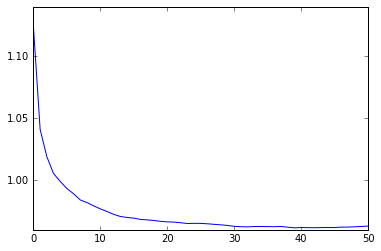

In [22]:
plt.plot([np.mean(loss_values[i:i+5]) for i in range(len(loss_values))])
plt.show()

## Evaluation

Accuracy is depend on the number of epoch that you set in partametrs part.

In [23]:
y_ = np.argmax(y_test,1) # ground truth
print metrics.classification_report(y_true= y_, y_pred= y_pred_lb)
print metrics.confusion_matrix(y_true= y_, y_pred= y_pred_lb)
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true= y_, y_pred= y_pred_lb) )
print("Log Loss: %0.6f" % metrics.log_loss(y_true= y_, y_pred= y_pred) )

             precision    recall  f1-score   support

          0       0.88      0.86      0.87       200
          1       0.45      0.43      0.44       200
          2       0.46      0.48      0.47       200
          3       1.00      1.00      1.00       200

avg / total       0.70      0.69      0.70       800

[[172  14  14   0]
 [ 11  87 102   0]
 [ 12  91  97   0]
 [  0   0   0 200]]
Classification accuracy: 0.695000
Log Loss: 0.585576


### Viz
Do you want to look at all the filters? lets use __utils__ to visualize it.

In [24]:
!wget --output-document utils1.py http://deeplearning.net/tutorial/code/utils.py
import utils1
from utils1 import tile_raster_images

--2017-10-22 03:05:32--  http://deeplearning.net/tutorial/code/utils.py
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/plain]
Saving to: 'utils1.py'

utils1.py           100%[===================>]   4.98K  --.-KB/s    in 0s      

2017-10-22 03:05:32 (556 MB/s) - 'utils1.py' saved [5097/5097]



Here you can plot the 32 filters in the first convolutional layer.

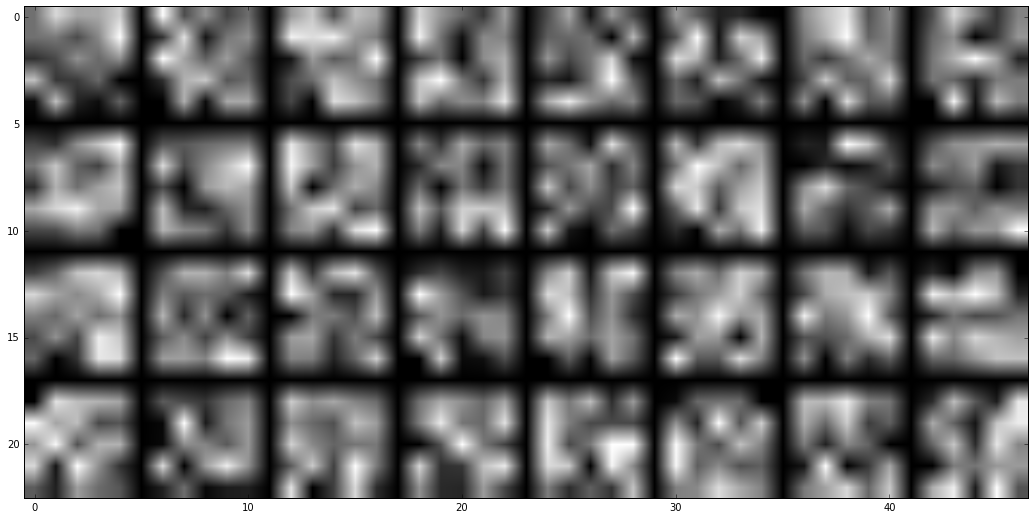

In [25]:
image = Image.fromarray(tile_raster_images(kernels_l1, img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Also, you can plot and take a look at some filters form second convolutional layers:

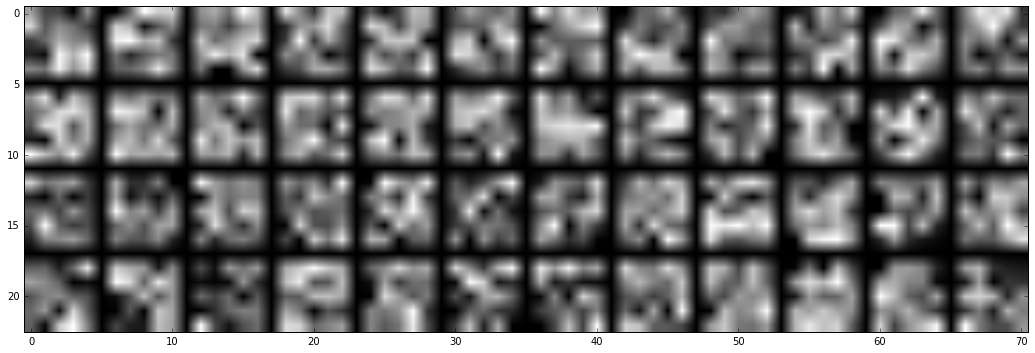

In [26]:
image = Image.fromarray(tile_raster_images(kernels_l2, img_shape=(5, 5) ,tile_shape=(4, 12), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

To underestand better, lets apply one os these filters on a sample signal (spectogram image). First, lets plot a sample spectogram:

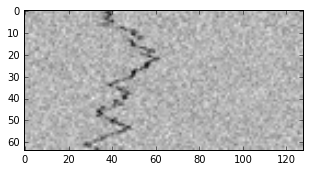

In [27]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage1 = X_test[3]
plt.imshow(np.reshape(sampleimage1,[64,128]), cmap="gray")

Now we apply different filters on them, and plot the result:

Instructions for updating:
Please use tf.global_variables instead.
loading model:  /tmp/SETI1_data//save/model.ckpt-140000
INFO:tensorflow:Restoring parameters from /tmp/SETI1_data//save/model.ckpt-140000


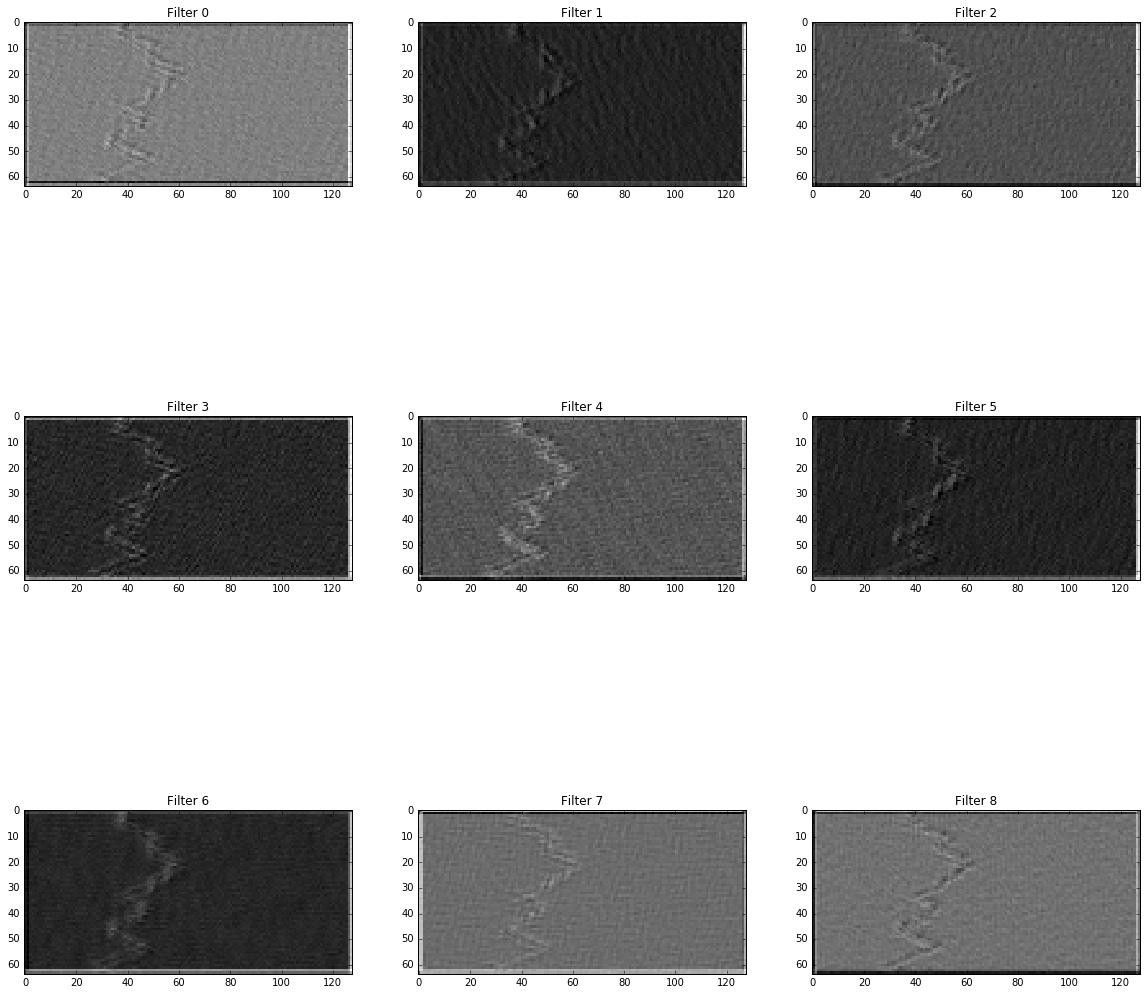

In [28]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver(tf.all_variables())
    
    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    if ckpt:
        print "loading model: ",ckpt.model_checkpoint_path
        saver.restore(sess, ckpt.model_checkpoint_path)
    ActivatedUnits1 = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage1,[1,64*128],order='F'),keep_prob:1.0})
    plt.figure(1, figsize=(20,20))
    n_columns = 3
    n_rows = 3
    for i in range(9):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(ActivatedUnits1[0,:,:,i], interpolation="nearest", cmap="gray")

## Want to learn more?

Running deep learning programs usually needs a high performance platform. PowerAI speeds up deep learning and AI. Built on IBM's Power Systems, PowerAI is a scalable software platform that accelerates deep learning and AI with blazing performance for individual users or enterprises. The PowerAI platform supports popular machine learning libraries and dependencies including Tensorflow, Caffe, Torch, and Theano. You can download a [free version of PowerAI](http://cocl.us/SETI-NIMBIX-PowerAI).

### Author:

<div class="teacher-image" style="    float: left;
    width: 115px;
    height: 115px;
    margin-right: 10px;
    margin-bottom: 10px;
    border: 1px solid #CCC;
    padding: 3px;
    border-radius: 3px;
    text-align: center;"><img class="alignnone wp-image-2258 " src="https://media.licdn.com/mpr/mpr/shrinknp_400_400/AAEAAQAAAAAAAAyFAAAAJGJlM2I2MmQzLTkxOWQtNDVhZi1hZGU0LWNlOWQzZDcyYjQ3ZA.jpg" alt="Saeed Aghabozorgi" width="178" height="178" /></div>
#### Saeed Aghabozorgi

[Saeed Aghabozorgi](https://ca.linkedin.com/in/saeedaghabozorgi), PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like deep learning, machine learning and statistical modelling on large datasets</p>


